## Investigating How Data Scientists Answered the Stack Overflow Survey

### Background
I am investigating the 2017 Stack Overflow survey results. A brief description of the survey and the relevant files can be found on [Kaggle](https://www.kaggle.com/stackoverflow/so-survey-2017).

### Questions
Since I am taking the Data Science Nanodegree program from Udacity, I am interested in how data scientists answered the questions in this survey.  The questions I will explore are:
1. How does the mean salary for a data scientist compare to other developer types?
2. How does the mean job satisfaction for a data scientist compare to other developer types?
3. What types of education do data scientists recommend?

In [63]:
# Import packages and read in data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Look at some basic descriptive statistics...
display(df.describe())
display(df.shape)

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


(19102, 154)

There are 19,102 rows in the dataset, with each corresponding to a single respondent.  Of the 154 columns, however, there are only 6 columns that have numerical data, which means that most of the columns have categorical responses, including the column that I am interested in exploring first: 'DeveloperType'.

In [3]:
# Look at the first 10 rows of DeveloperType:
df['DeveloperType'].head(10)

0                                                  NaN
1                                                  NaN
2                                                Other
3                                                  NaN
4    Mobile developer; Graphics programming; Deskto...
5                                                  NaN
6                                                  NaN
7                                        Web developer
8                      Web developer; Mobile developer
9     Mobile developer; Desktop applications developer
Name: DeveloperType, dtype: object

Not every respondent provided a developer type, meaning that my sample size will be less than the 19,102 in the dataset.  I also see some respondents provided multiple answers, separated by semicolons, which need to be parsed out.

In [4]:
# Create a function to identify unique responses in DeveloperType
def unique_responses(df_column):
    '''
    Identifies the unique responses in a column of the Stack Overflow dataset
    
    df_column: pandas Series, the column from the pandas Dataframe to parse
    
    returns response_set, a set of the unique responses
    '''
    # Initialize the set
    response_set = set()
    
    # Loop through the column
    for response in df_column:
        # Split the response by semicolon and a space (; ) into multiple developer types
        dev_types = str(response).split('; ')
        # For each developer type in the response, add it to the set of responses
        for dev_type in dev_types:
            response_set.add(dev_type)

    return response_set

In [5]:
# View unique responses in DeveloperType
developer_responses = unique_responses(df['DeveloperType'])
developer_responses

{'Data scientist',
 'Database administrator',
 'Desktop applications developer',
 'DevOps specialist',
 'Developer with a statistics or mathematics background',
 'Embedded applications/devices developer',
 'Graphic designer',
 'Graphics programming',
 'Machine learning specialist',
 'Mobile developer',
 'Other',
 'Quality assurance engineer',
 'Systems administrator',
 'Web developer',
 'nan'}

There are 15 different unique responses to the 'DeveloperType' question, including 'Other' and 'nan' (meaning the respondent didn't answer this question).  Of the 13 possible Developer types listed, 'Data scientist' and 'Machine learning specialist' are the only two that I would consider to be in the data science realm.  I am curious how these two types compare to the rest of the types listed.  But first, I want to know how many respondents fall under each developer type.

In [6]:
# Create a dictionary of the number of responsed for each DeveloperType

# Initialize a dictionary for counting
response_dict = dict.fromkeys(developer_responses,0)
# Loop through each row of the dataframe
for response in df['DeveloperType']:
    # For each developer type in the response, increment the dictionary count by 1
    for dev_type in str(response).split('; '):
        response_dict[dev_type] += 1

response_dict

{'Embedded applications/devices developer': 1174,
 'Quality assurance engineer': 429,
 'Data scientist': 1077,
 'Systems administrator': 1479,
 'Web developer': 10086,
 'DevOps specialist': 1505,
 'Machine learning specialist': 488,
 'nan': 5330,
 'Mobile developer': 2905,
 'Other': 996,
 'Graphics programming': 584,
 'Database administrator': 1827,
 'Desktop applications developer': 3869,
 'Graphic designer': 439,
 'Developer with a statistics or mathematics background': 1479}

In [7]:
# Visualize the response dictionary in a dataframe
response_df = pd.DataFrame.from_dict(response_dict,orient='index',columns=['Count'])
response_df.sort_values(by='Count',ascending=False)

,Count
Web developer,10086
nan,5330
Desktop applications developer,3869
Mobile developer,2905
Database administrator,1827
DevOps specialist,1505
Systems administrator,1479
Developer with a statistics or mathematics background,1479
Embedded applications/devices developer,1174
Data scientist,1077


In [8]:
# Since the respondents that did not answer this question do not provide any information to help answer my questions,
# I will drop that response from my dataframe
response_df.drop(index='nan',inplace=True)

In [9]:
# Add a column to the dataframe to reflect frequency of respondents by developer type
# NOTE: This is the number of people (respondents) who included each developer type in their response
num_respondents = 19102-5330 # Total number of respondents minus 'nan's
response_df['Respondent_Freq'] = response_df['Count']/num_respondents

In [10]:
# Create a sorted dataframe for easier plotting
response_df_sorted = response_df.sort_values(by='Count',ascending=False)

# Visualize
response_df_sorted

,Count,Respondent_Freq
Web developer,10086,0.732409
Desktop applications developer,3869,0.280953
Mobile developer,2905,0.210951
Database administrator,1827,0.132670
DevOps specialist,1505,0.109288
Systems administrator,1479,0.107400
Developer with a statistics or mathematics background,1479,0.107400
Embedded applications/devices developer,1174,0.085252
Data scientist,1077,0.078208
Other,996,0.072326


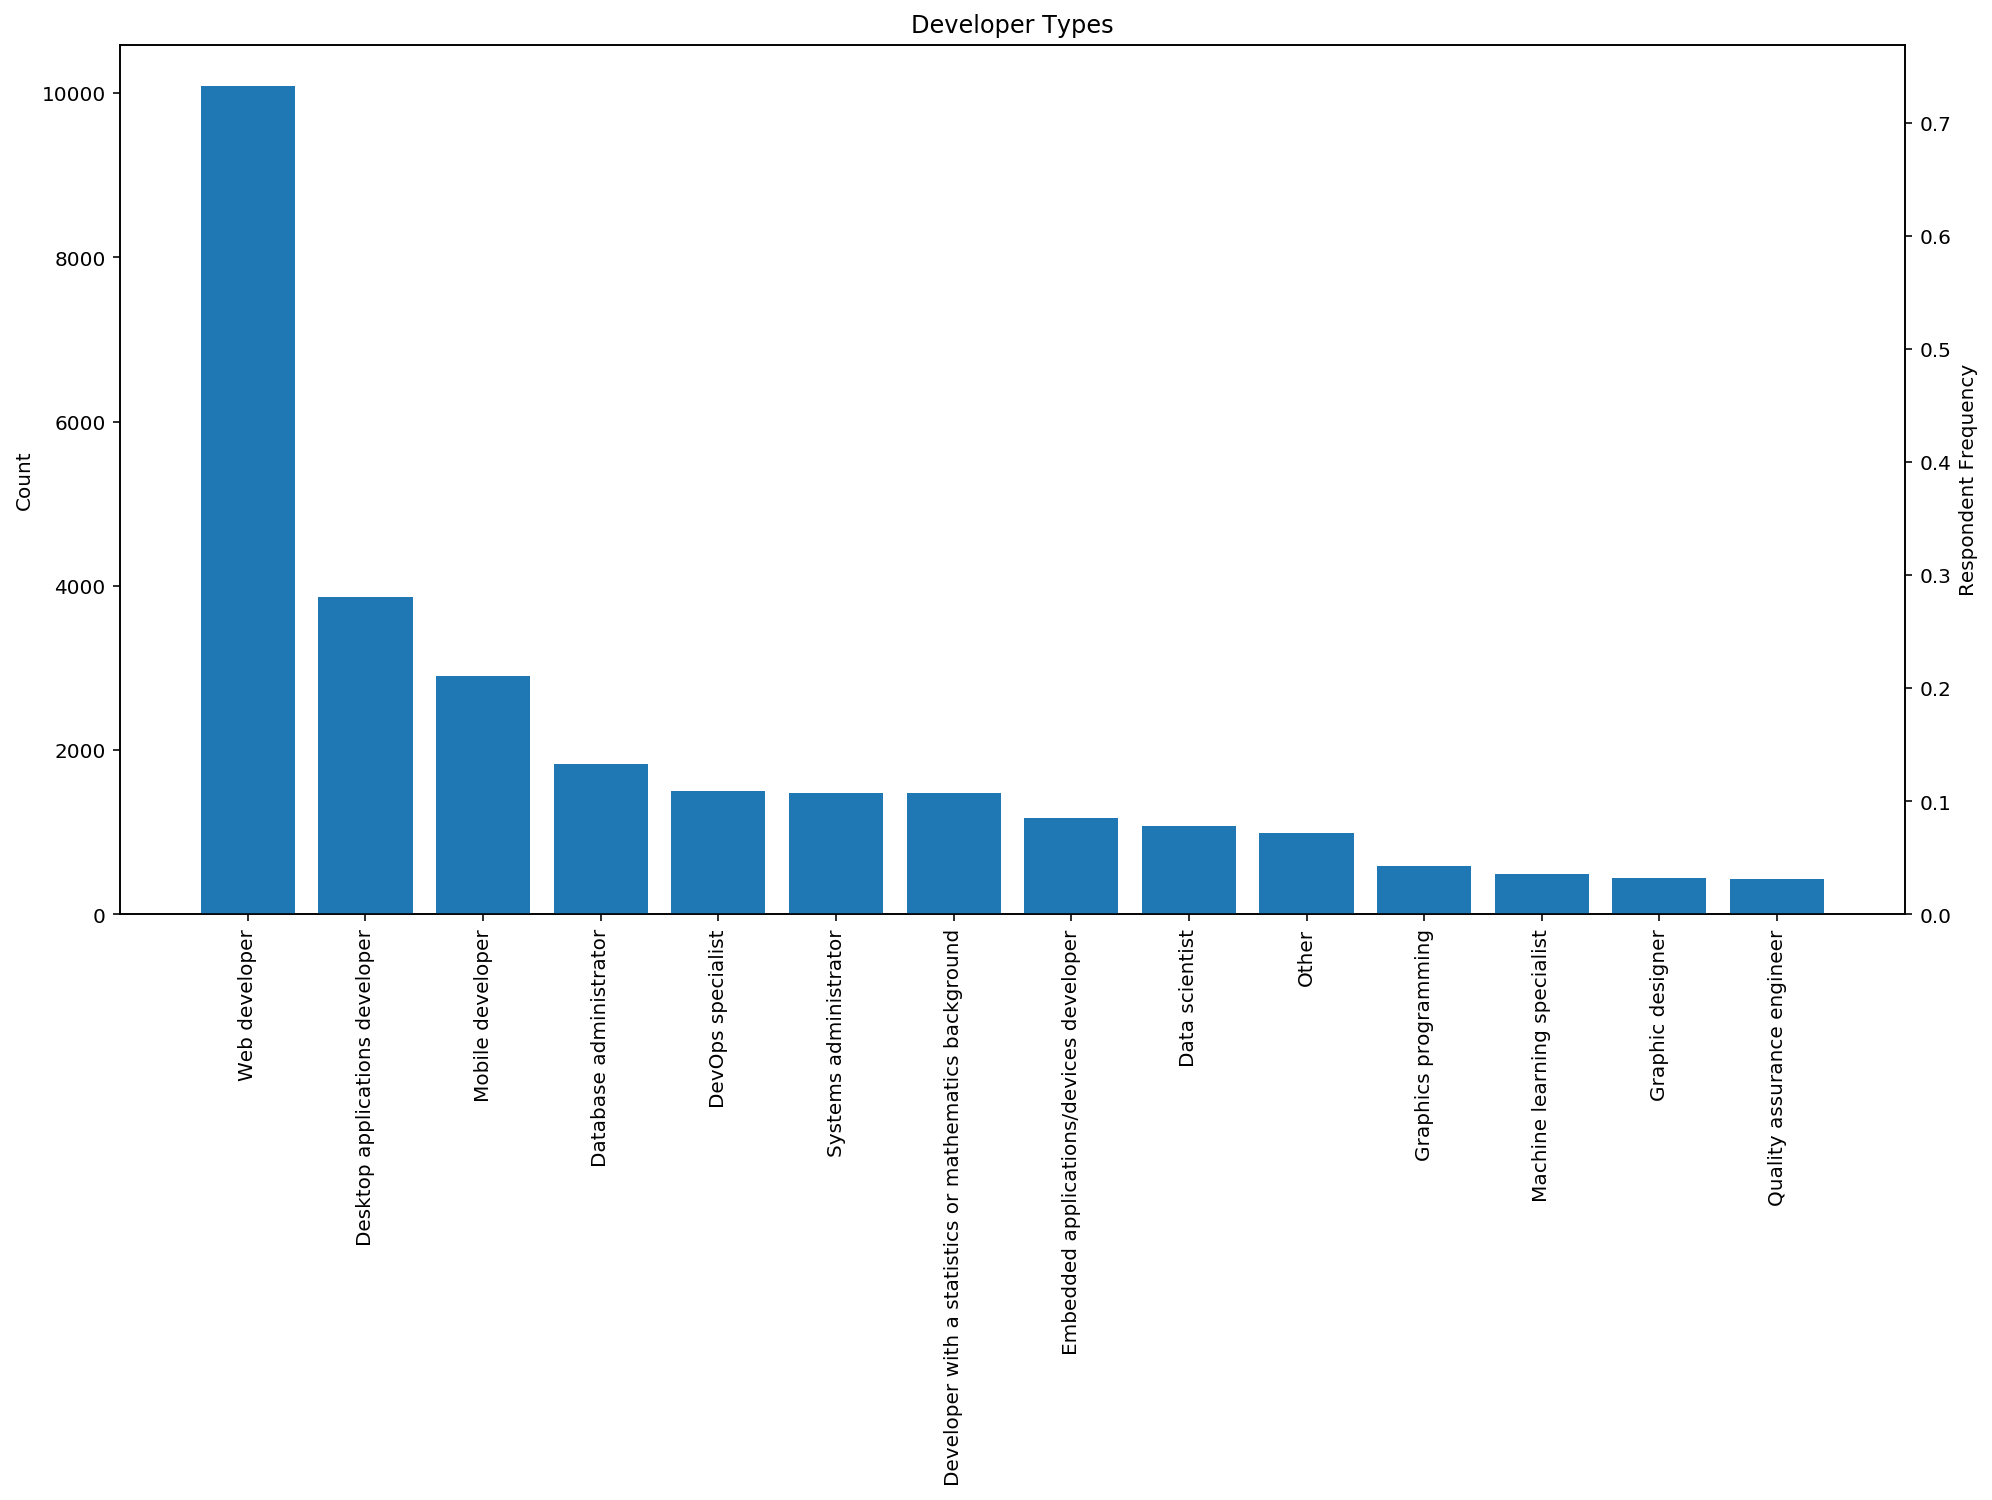

In [11]:
# Plot responses by developer type
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.bar(response_df_sorted.index,response_df_sorted['Count'])
ax2 = ax1.twinx()
ax2.bar(response_df_sorted.index,response_df_sorted['Respondent_Freq'])
ax1.set_xticklabels(response_df_sorted.index, rotation=90)
ax1.set_ylabel('Count')
ax2.set_ylabel('Respondent Frequency')
ax1.set_title('Developer Types')
plt.show()

In [12]:
num_responses = response_df_sorted['Count'].sum()
print('The number of respondents:',num_respondents)
print('The number of responses:',num_responses)
print('The average number of responses per respondent: {:.2f}'.format(num_responses/num_respondents))

The number of respondents: 13771
The number of responses: 28337
The average number of responses per respondent: 2.06


The most common response was 'Web developer' with over 10,000 responses, making up over 70% of respondents.  Data scientists made up 1077 responses (7.8% of respondents) and 'Machine learning specialists' were included in 488 responses (3.5%).  I will need to be careful when comparing the mean salary and job satisfaction for Web developers to those of data scientists and machine learning specialists since they have vastly different sample sizes.  Outliers could heavily skew the results of the developer types with small sample sizes.  Furthermore, the fact that respondents were allowed to select multiple developer types, with the average number of developer types per respondent being 2, means it is going to be difficult to isolate the effect that being a data scientist or machine learning specialist has on salary and job satisfaction.

This initial breakdown of the developer types counted each type in isolation.  Next, I need to identify which developer type(s) each respondent selected.  I will perform onehot encoding, creating 14 new columns in the dataframe to capture whether each respondent selected a particular developer type.  Pandas has a very convenient function called *get_dummies* for this process, but it will not work on the 'DeveloperType' column because it has multiple responses in a given row and the function assumes one response per row.

In [13]:
# Write a function to loop through every row and assign 1's to the developer type columns included in 'DeveloperType'
def generate_onehot(df,column,separator):
    '''
    Loops through the dataframe (df) and onehot encodes the column
    This function is intended for onehot encoding a column that has multiple entries in a single column that need to be parsed
    Drops the original column
    
    df: pandas Dataframe
    column: string, the column in df to be encoded
    separator: string, the separator between multiple entries in a single row
    
    returns: df, pandas Dataframe with onehot encoded columns and without the original column
    '''
    # Copy the dataframe
    df_copy = df.copy()
    
    # Initialize the set of possible responses
    response_set = set()
    
    # Loop through the column
    for response in df_copy[column]:
        # Split the response by the separator into multiple entries
        entries = str(response).split(separator)
        # For each entry in the response, add it to the set of responses
        for entry in entries:
            response_set.add(entry)
    
    # Add new columns for the responses with all rows containing 0
    for new_column in list(response_set):
        df_copy[new_column] = 0
    
    # Loop through the rows of the dataframe
    for row in range(len(df_copy)):
        # Split the response by the separator into multiple entries
        entries = str(df_copy.loc[row,column]).split(separator)
        # Set the value in the new column equal to 1
        for entry in entries:
            df_copy.loc[row,entry] = 1
    
    # Drop the original column
    df_copy.drop(columns=column, inplace=True)
    
    return df_copy

In [21]:
# Call the generate_onehot function on the original dataset
original_df = pd.read_csv('survey_results_public.csv')
encoded_df = generate_onehot(original_df,'DeveloperType','; ')

In [22]:
# View the first 10 rows of the encoded dataframe to verify onehot encoding
encoded_df.head(10)

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,DevOps specialist,Machine learning specialist,nan,Mobile developer,Other,Graphics programming,Database administrator,Desktop applications developer,Graphic designer,Developer with a statistics or mathematics background
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,0,0,1,0,0,0,0,0,0,0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,0,0,1,0,0,0,0,0
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,1,0,0,0,0,0,0,0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,0,0,0,1,0,1,0,1,0,0
5,6,Student,"Yes, both",New Zealand,"Yes, full-time","Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
6,7,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Master's degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...",20 to 99 employees,...,0,0,1,0,0,0,0,0,0,0
7,8,Professional developer,"Yes, both",Poland,No,Employed full-time,Master's degree,Computer science or software engineering,All or almost all the time (I'm full-time remote),Fewer than 10 employees,...,0,0,0,0,0,0,0,0,0,0
8,9,Professional developer,"Yes, I program as a hobby",Colombia,"Yes, part-time",Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","5,000 to 9,999 employees",...,0,0,0,1,0,0,0,0,0,0
9,10,Professional developer,"Yes, I program as a hobby",France,"Yes, full-time","Independent contractor, freelancer, or self-em...",Master's degree,Computer science or software engineering,It's complicated,NaN,...,0,0,0,1,0,0,0,1,0,0


In [30]:
# Drop the 'nan' column
encoded_df.drop(columns='nan', inplace=True)
# Add a row to calculate how many Developer Types each person provided
encoded_df['NumDevTypes'] = encoded_df.iloc[:,-14:].sum(axis=1)

In [31]:
encoded_df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,DevOps specialist,Machine learning specialist,Mobile developer,Other,Graphics programming,Database administrator,Desktop applications developer,Graphic designer,Developer with a statistics or mathematics background,NumDevTypes
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,0,0,0,0,0,0,0,0,0,0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,0,1,0,0,0,0,0,1
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,0,0,0,0,0,0,0,0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,0,0,1,0,1,0,1,0,0,3


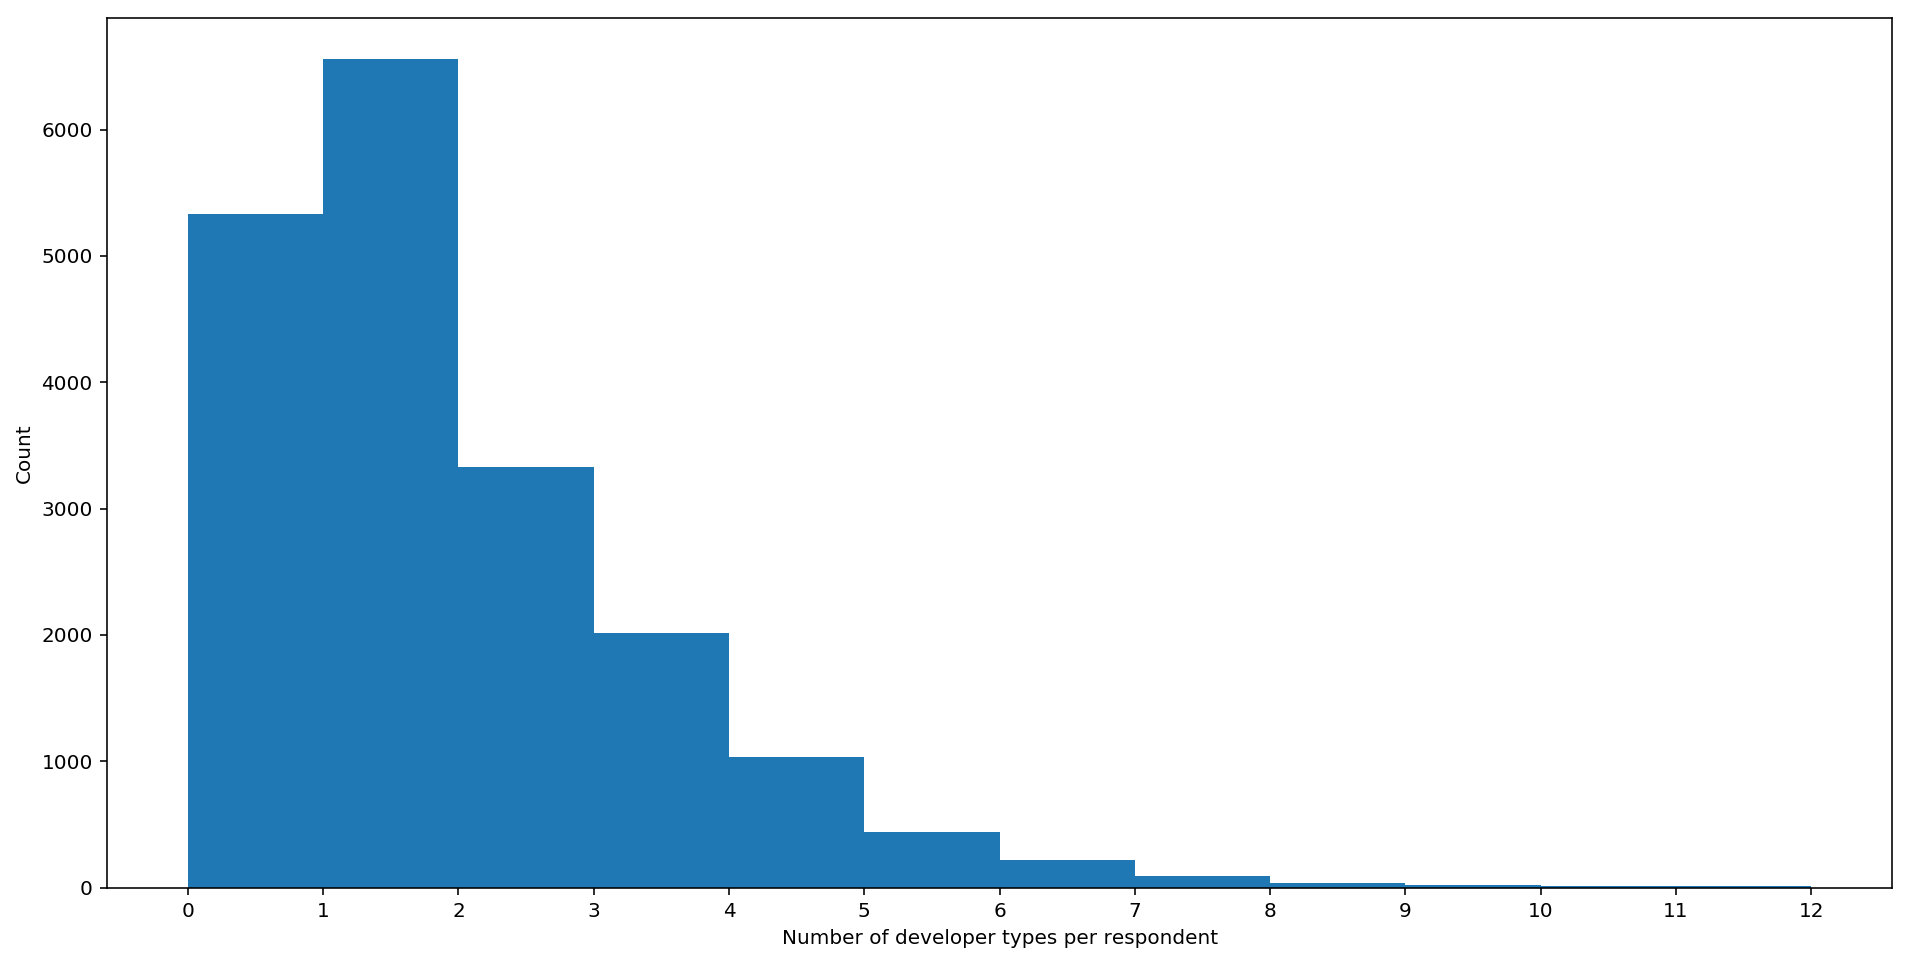

In [42]:
# Visualize the distribution of developer types
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(encoded_df['NumDevTypes'],bins=range(encoded_df['NumDevTypes'].max()))
ax.set_xticks(range(encoded_df['NumDevTypes'].max()))
ax.set_ylabel('Count')
ax.set_xlabel('Number of developer types per respondent')
#encoded_df['NumDevTypes'].plot(kind='hist')
plt.show()

In [45]:
encoded_df['NumDevTypes'].value_counts(sort=False)

0     5330
1     6556
2     3326
3     2018
4     1035
5      444
6      220
7       91
8       34
9       24
10       9
11       6
12       3
13       6
Name: NumDevTypes, dtype: int64

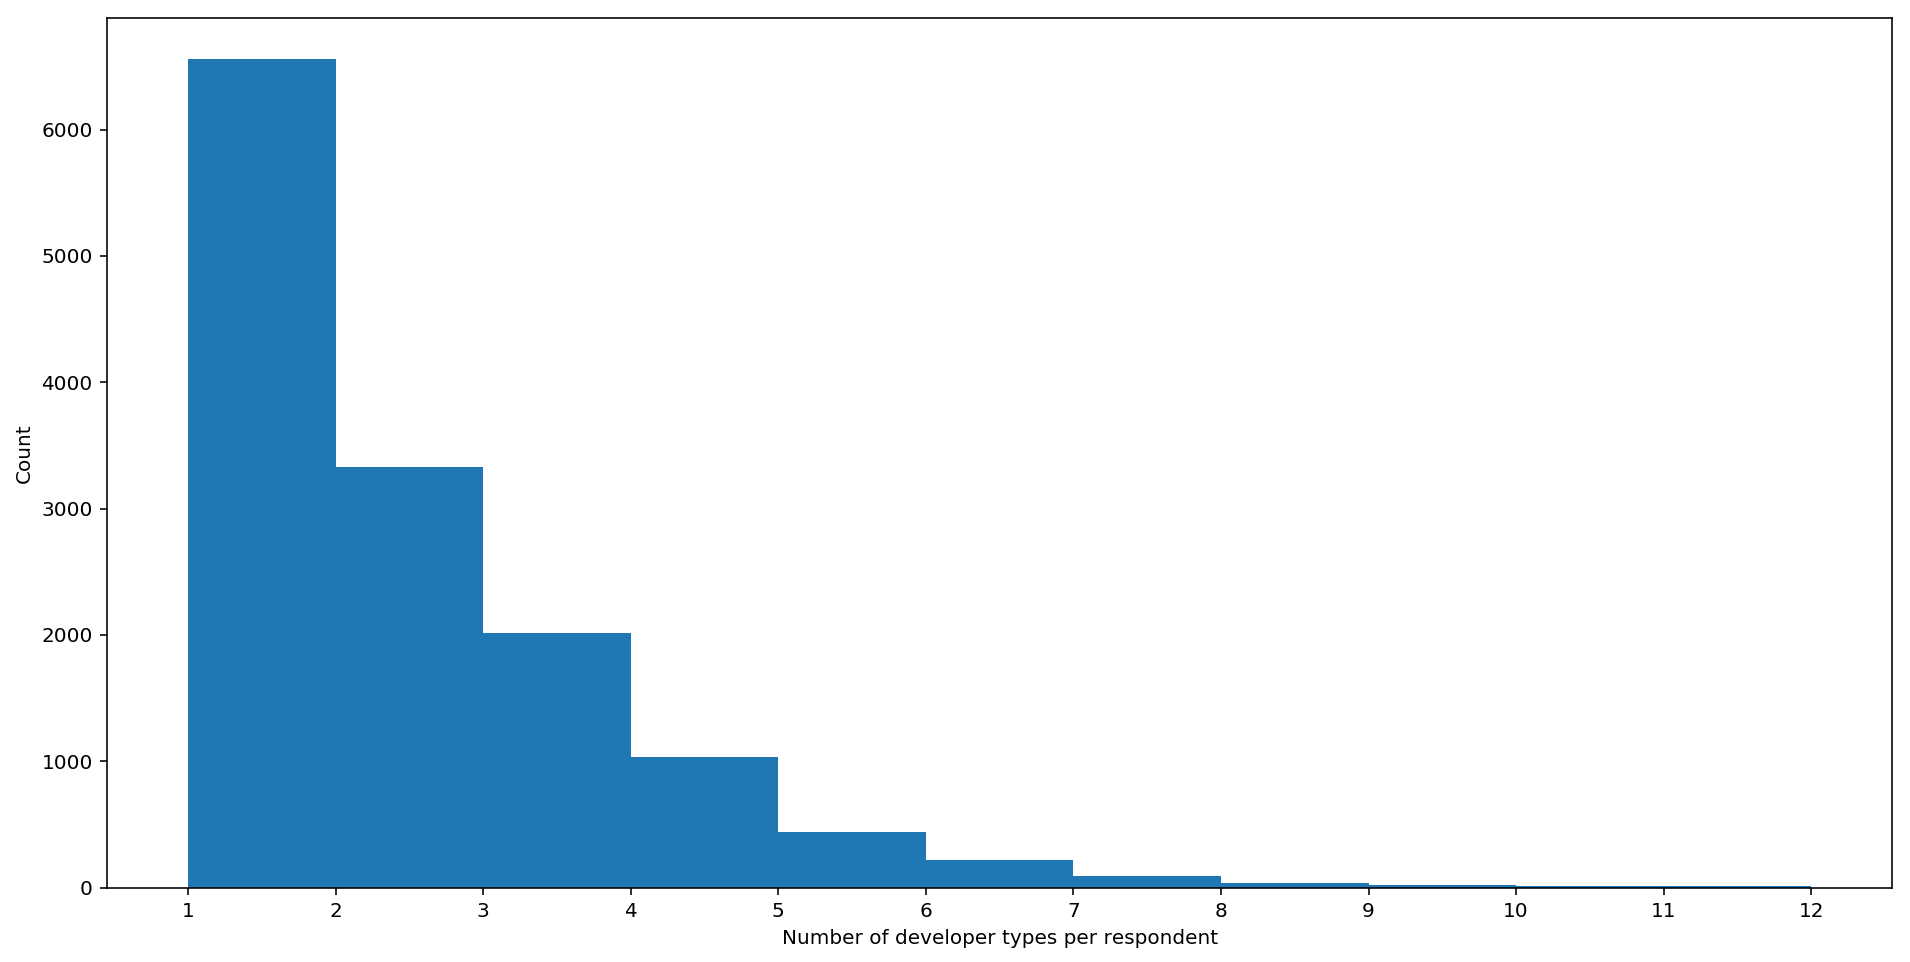

In [43]:
# Visualize the distribution of developer types, excluding null responses
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(encoded_df.loc[encoded_df['NumDevTypes']>0,'NumDevTypes'],bins=range(1,encoded_df['NumDevTypes'].max()))
ax.set_xticks(range(1,encoded_df['NumDevTypes'].max()))
ax.set_ylabel('Count')
ax.set_xlabel('Number of developer types per respondent')
plt.show()

One way to compare the effect of data scientists and machine learning specialists on salary and job satisfaction is to split the respondents into those that included 'Data scientist' or 'Machine learning specialist' in their survey response to those that did not.

In [49]:
encoded_df.groupby('Data scientist')['Salary'].mean()

Data scientist
0    57811.470365
1    65572.904236
Name: Salary, dtype: float64

In [50]:
encoded_df.groupby('Data scientist')['JobSatisfaction'].mean()

Data scientist
0    6.976594
1    7.335283
Name: JobSatisfaction, dtype: float64

In [54]:
encoded_df.groupby(['Data scientist','Machine learning specialist'])['Salary'].mean()

Data scientist  Machine learning specialist
0               0                              57702.467161
                1                              66324.805294
1               0                              63595.815488
                1                              70789.053271
Name: Salary, dtype: float64

In [55]:
encoded_df.groupby(['Data scientist','Machine learning specialist'])['JobSatisfaction'].mean()

Data scientist  Machine learning specialist
0               0                              6.973240
                1                              7.244318
1               0                              7.279570
                1                              7.482270
Name: JobSatisfaction, dtype: float64

In [56]:
encoded_df.groupby('Data scientist')['Machine learning specialist'].mean()

Data scientist
0    0.010485
1    0.277623
Name: Machine learning specialist, dtype: float64

In [57]:
encoded_df.groupby('Machine learning specialist')['Data scientist'].mean()

Machine learning specialist
0    0.041796
1    0.612705
Name: Data scientist, dtype: float64

In [62]:
corr = encoded_df.iloc[:,-15:-1].corr()

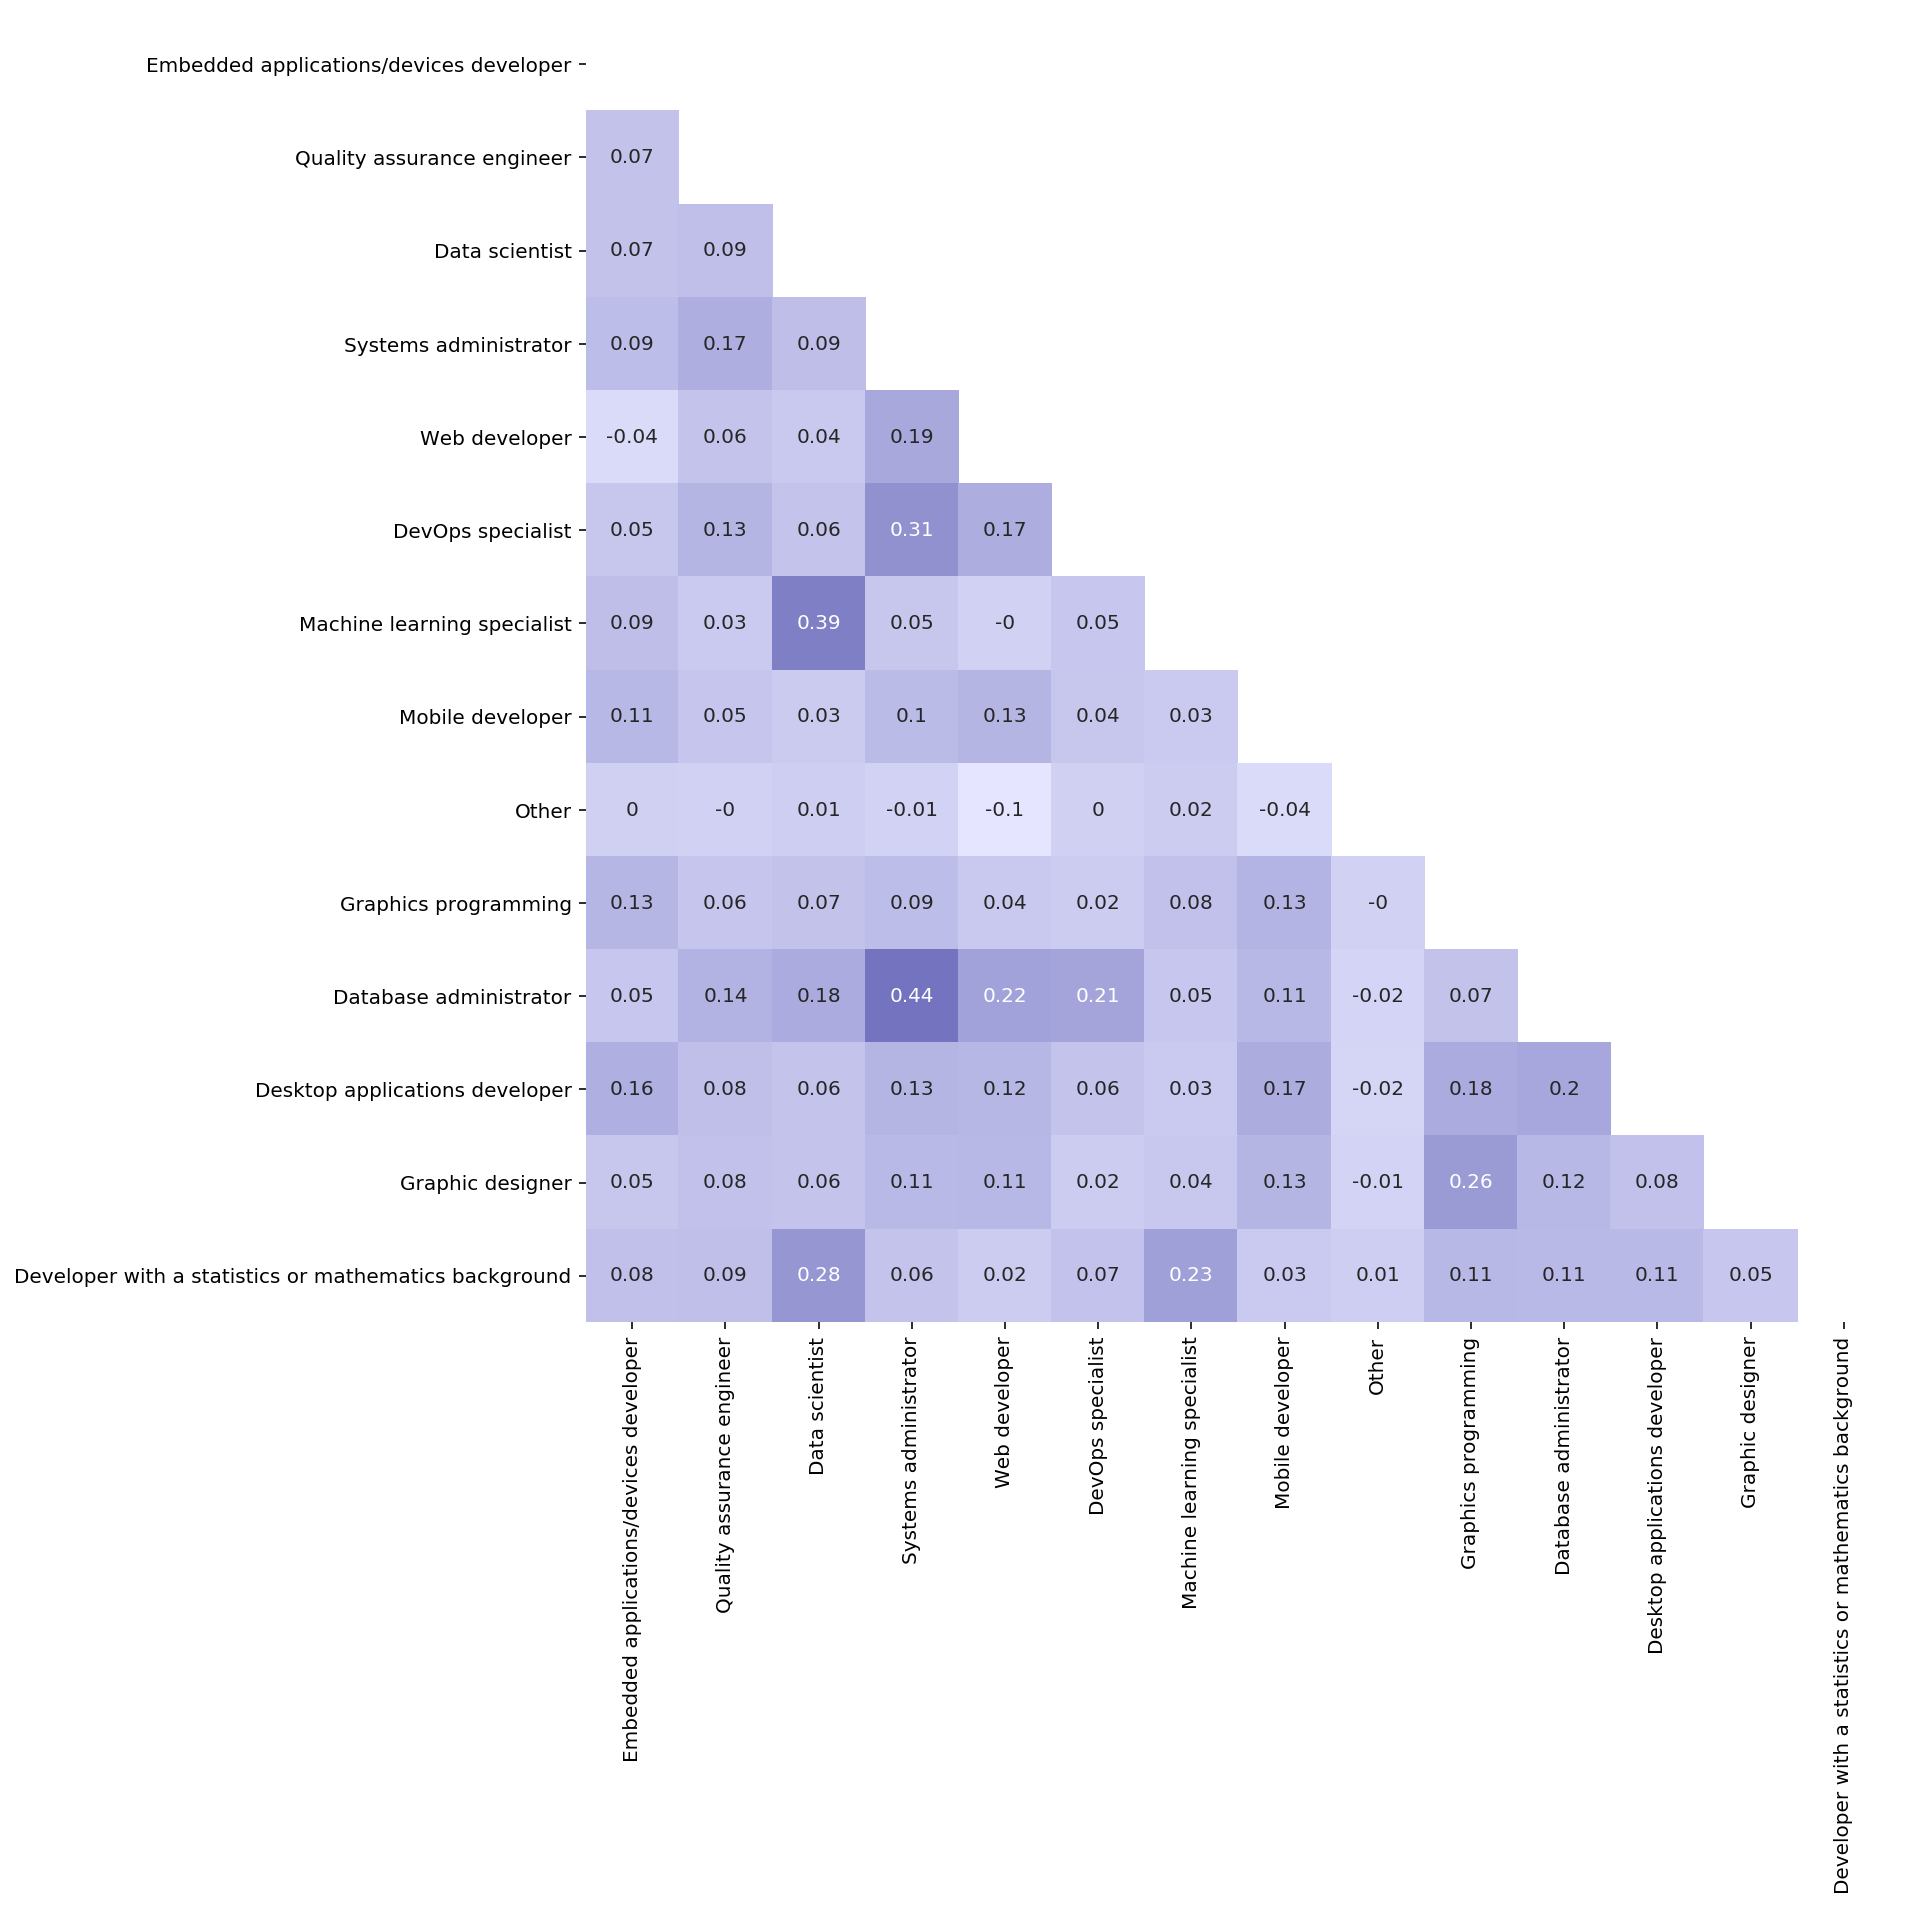

In [96]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette('navy',n_colors=5, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=np.round(corr.values,2), square=True, cbar=False)

To really separate the effect of being a data scientist on salary and job satisfaction, I need to do more than just compare two different developer types.  Looking at the mean salary of data scientists and comparing it to the mean salary of those who are not data scientists does not account for all of the other potential developer types.  A better way to do this would be to create linear models to predict salary and job satisfaction and look at the feature weights to see which developer type has the biggest impact on each.

In [159]:
# Create a new dataframe with only the features I am interested in - DeveloperType, Salary, and JobSatisfaction
model_df = original_df[['DeveloperType','Salary','JobSatisfaction']]

In [160]:
# Visualize first 5 rows
model_df.head()

,DeveloperType,Salary,JobSatisfaction
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Other,113750.0,9.0
3,NaN,NaN,3.0
4,Mobile developer; Graphics programming; Deskto...,NaN,8.0


I need to handle the 'NaN's in each of the three columns.  For the 'DeveloperType' column, this is my input column into a model.  I could drop the rows with 'NaN' or keep them and impute a value into those rows.  Before deciding, I am curious whether there are Salary and Job satisfaction values reported by respondents who didn't answer the developer type question.

In [169]:
# Generate the onehot encoded dataframe for 'DeveloperType'
encoded_model_df = generate_onehot(model_df,'DeveloperType','; ')

In [170]:
# Look at descriptive stats for Salary and Job Satisfaction for missing values for 'DeveloperType'
encoded_model_df.loc[encoded_model_df['nan']==1][['Salary','JobSatisfaction']].describe()

,Salary,JobSatisfaction
count,1.0,1892.000000
mean,125000.0,6.661734
std,NaN,2.304149
min,125000.0,0.000000
25%,125000.0,5.000000
50%,125000.0,7.000000
75%,125000.0,8.000000
max,125000.0,10.000000


In [163]:
# Look at descriptive statistics for Salary and Job Satisfaction for Web developers for comparison
encoded_model_df.loc[encoded_model_df['Web developer']==1][['Salary','JobSatisfaction']].describe()

,Salary,JobSatisfaction
count,3669.000000,9813.000000
mean,56814.961123,7.040151
std,39866.740326,2.079548
min,0.000000,0.000000
25%,26881.720430,6.000000
50%,50000.000000,7.000000
75%,80645.161290,8.000000
max,195000.000000,10.000000


There appears to be one respondent who provided a (rather high) salary without reporting a developer type.  I am comfortable dropping this one data point from the model for predicting salary.  However, of the 5330 respondents who did not answer the developer type question, 1892 of them did provide a job satisfaction rating.  I will keep these rows so as not to ignore these data.  I will assign these respondents to 'Web developer' since they made up 70% of the respondents and also have a similar distribution of Job satisfaction ratings as those with missing developer types.

In [171]:
# Fill 'NaN's in 'DevloperType' with 'Web developer'
model_df.fillna({'DeveloperType':'Web developer'},inplace=True)

In [172]:
# Visualize first 5 rows of dataframe.  There should not be 'NaN' values in 'DeveloperType'
model_df.head()

,DeveloperType,Salary,JobSatisfaction
0,Web developer,NaN,NaN
1,Web developer,NaN,NaN
2,Other,113750.0,9.0
3,Web developer,NaN,3.0
4,Mobile developer; Graphics programming; Deskto...,NaN,8.0


In [173]:
# Regenerate the onehot encoded df, this time without NaN values in the 'DeveloperType' column
encoded_model_df = generate_onehot(model_df,'DeveloperType','; ')